<a href="https://colab.research.google.com/github/Starboy177/DataScience/blob/main/Copy_of_Unit8ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 8 Exercises: The Art of BART

These exercises are grouped into two parts:

- Questions on the nature of decision trees, random forests, and BART models
- An oppurtunity to practice implementing and analyzing a BART model.

Enjoy!

## Bartian Theory

**Task1**:

Draw a decision tree--on a physical piece of paper--that predicts how many calories you burn in a day, using time you spent exercising that day (in minutes) as a predictor.

To help you understand what you're doing with this tree, seperately create an x/y plot with time exercising as x, and calories burned as y.

If this seems to easy, then add another variable or two (type of exercise?), and/or increase the depth of your tree.

You do not have to show me or turn in your tree to earn credit for this question, although I would like to see your drawing.

**Task2**:

What is a decision tree? How do they work?

a decision tree is similar to a flow chart, but with several restrictions. Each node only has one parent node and each layer of the tree sorts the predictor values into subsets of the predicted values. A decision tree sorts data into branches with different options, and a leaf node is the final node, where you cannot go any farther.

**Task3**:

What does the "depth" of a decision tree mean?

How do I know if a tree is too deep, or not deep enough?

The "depth" of a decision tree refers to the number of levels from the root node to the farthest leaf node. A tree is too deep if it overfits the data by capturing noise, and too shallow if it underfits by failing to capture important patterns.

**Task4:**

How are BART models similar and different from a decision tree?

A BART model is kind of like multiple decision trees that uses Bayesian methods for uncertainty estimation and regularization, while a decision tree relies on a single tree and can overfit without pruning. BART combines multiple trees to improve accuracy and prevent overfitting.

**Task5**:

Why would we use a BART model instead of a decision tree?

If we wanted to average predictions from multiple trees, and reduced overfitting.

## Bartian Penguins

**Task6**:

Create a BART model that uses flipper length, bill depth, and bill length to predict body mass in penguins, and make a ppc to check its fit

Code for loading the data is below. You'll need to do everything else yourself.

Remember to use my notes as a reference, and to copy and paste from them when it makes sense to.

Oh, and try a normal likelihood.

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from sklearn import tree
!pip install pymc-bart
!pip install preliz
import pymc_bart as pmb
import preliz as pz

In [ ]:
#drop the incomplete rows from the data
url="https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/penguins.csv"
penguins = pd.read_csv(url).dropna()

In [ ]:
features = ["flipper_length", "bill_length","bill_depth"]
X = penguins[features]
Y = penguins["body_mass"].to_numpy()

In [ ]:
with pm.Model() as model_octps:
    s = pm.HalfNormal('s',1000)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Normal("y", mu=μ, sigma=s,  observed=Y)
    idata_octps = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

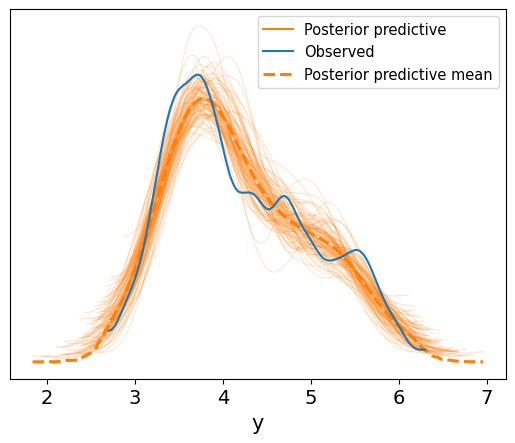

In [ ]:
pm.sample_posterior_predictive(idata_octps,model_octps, extend_inferencedata=True)
az.plot_ppc(idata_octps, num_pp_samples=100, colors=["C1", "C0", "C1"])

**Task7**:

Plot flipper length versus body mass,

and then plot the posterior predictve from the model over the data.
You're going to copy paste the plotting code from the notes, fyi.

In [ ]:
posterior_mean = idata_octps.posterior["μ"]

μ_hdi = az.hdi(ary=idata_octps, group="posterior", var_names=["μ"], hdi_prob=0.74)
pps = az.extract(
    idata_octps, group="posterior_predictive", var_names=["y"]
).T

In [ ]:
Xn = X.to_numpy()

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


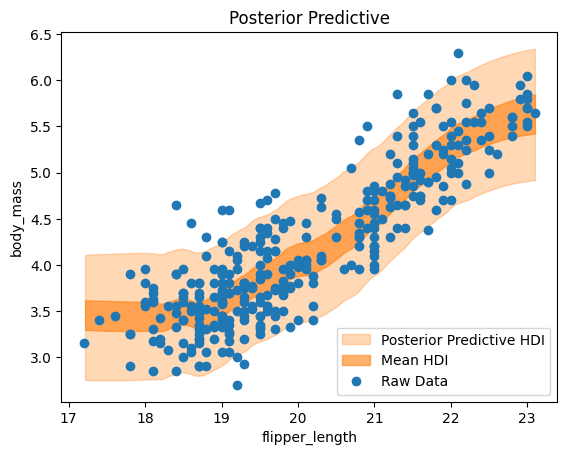

In [ ]:
idx = np.argsort(Xn[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=Xn[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
)

az.plot_hdi(
    x=Xn[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax.plot(penguins["flipper_length"], penguins["body_mass"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="flipper_length",
    ylabel="body_mass",
);

**Task8**:

Interpret the plot above in context. Do you think it captures the true association between flipper length and body mass in penguins? Why or why not? Make sure to reference specific things you see in the plot.

It seems like the model performs well overall,but there are some missing points here and there. While it struggles with consistently plotting the higher points, it accurately captures most of the lower ones, as it only misses two of those point, so it is pretty good overall. It also effectively follows the general trend and slope.

**Task9**:

Create partial depnedence plots (pdps), individual conditional expectation (ice) plots, and a variable importance plot for the BARTpenguin model.

array([<Axes: xlabel='flipper_length'>, <Axes: xlabel='bill_length'>,
       <Axes: xlabel='bill_depth'>], dtype=object)

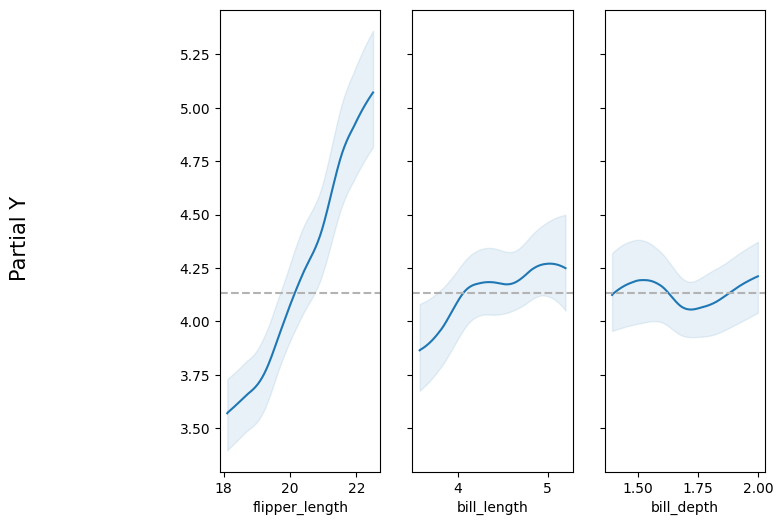

In [ ]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

array([<Axes: xlabel='flipper_length'>, <Axes: xlabel='bill_length'>,
       <Axes: xlabel='bill_depth'>], dtype=object)

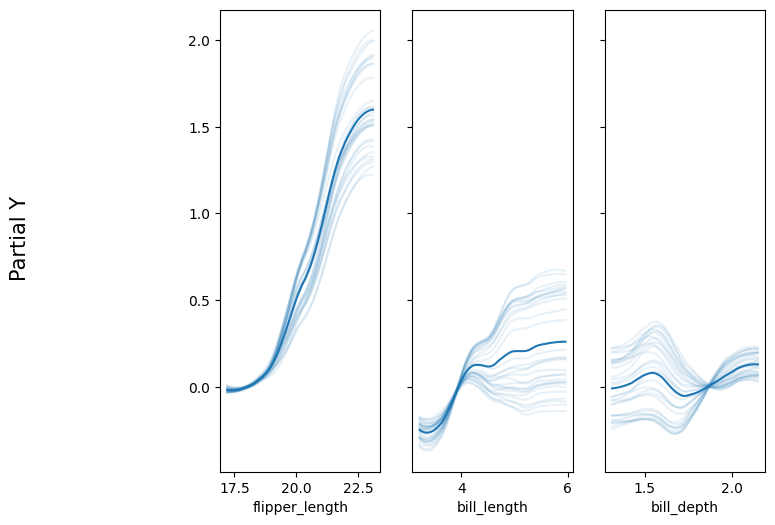

In [ ]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

<Axes: ylabel='R²'>

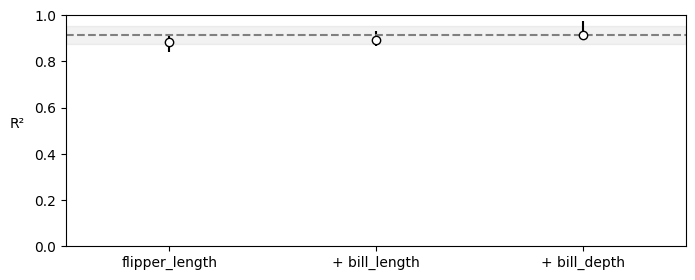

In [ ]:
vi_counties = pmb.compute_variable_importance(idata_octps, μ_, X)
pmb.plot_variable_importance(vi_counties)

**Task10**:

Using the above plots, make an argument about which variable(s) is/are most important in predicting body mass in penguins.

What is the relationship for each variable to body mass, when you take the other variables into account?

Is that relationship complicated by interactions between variables? How do you know?

Make sure to reference specific things you see in each plot, to justify your decisions and comments.

Based on the ICE and PDP plots, flipper length appears to have the strongest impact, as its correlation is clearly reflected in the slope. While bill length and bill depth also show some correlation, it's not as pronounced as with flipper length. Furthermore, the varying slopes in the bill length and bill depth plots suggest there might be more complexity at play, hinting at potential interactions between these two variables, or possibly an unknown third variable influencing them.